In this lab we are starting to look at comparison problems (text similarity models) by using corpus similarity measures to find out how close corpora are in the aggregate. We will use *register* as a case study, comparing data from tweets, web pages, and Wikipedia across several languages.

Let's start by getting our environment ready.

In [1]:
from text_analytics import TextAnalytics
import os
import pandas as pd

ai = TextAnalytics()
ai.data_dir = os.path.join(".", "data")
print("Done!")

Done!


We next load our corpus, from a folder that contains the same registers across many languages. Let's look at English first. The column "Text" contains samples and the column "Register" tells us which source the data is from.

In [2]:
file = os.path.join(ai.data_dir, "register", "Register.eng.gz")
df = pd.read_csv(file)
print(df)

    Register                                               Text
0         wk   was a japanese film director and screenwriter...
1         wk   at the time george ii had to accompanied trux...
2         wk   even before the building was completed there ...
3         wk   some examples of fictional colombian settings...
4         wk   red barron and vanderbilts lynn bomar were th...
..       ...                                                ...
420       cc   my name is gerri fairfield i taught for <num>...
421       cc   a bill to authorize the administrator of the ...
422       cc   protecting american taxpayers and homeowners ...
423       cc   unfunded mandates accountability act of <num>...
424       cc   department of homeland security insider threa...

[425 rows x 2 columns]


So far we've worked with text classifiers, so let's try a classification-based approach. In this case we feed the samples into the classifier and use a vector of function-word frequencies to predict which register each sample belongs to.

In [3]:
report = ai.shallow_classification(df, labels = "Register", features = "style", classifier = "lm")
print(report)

              precision    recall  f1-score   support

          cc       1.00      1.00      1.00        13
          tw       1.00      1.00      1.00        16
          wk       1.00      1.00      1.00        14

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43



We see that the classifier works quite well, which tells us that there is a significant difference in the grammar of English as it appears across these different registers. But that isn't actually our main question: instead of a discrete boundary between registers, it would be nice to have a range of similarity values: given many samples from each, what is the overall similarity?

We start below by randomly choosing some pairs to get a scalar measure for.

In [4]:
for i in range(10):
    test1 = df.sample(n=1)
    test2 = df.sample(n=1)
    similarity = ai.get_corpus_similarity(test1.Text.tolist(), test2.Text.tolist(), language='en')
    print(test1.loc[0:,"Register"].values, test2.loc[0:,"Register"].values, similarity)


['wk'] ['tw'] 0.3351646757020927
['wk'] ['tw'] 0.3499664052459379
['wk'] ['tw'] 0.32631412124228165
['cc'] ['tw'] 0.420265961250327
['cc'] ['tw'] 0.46621054322968897
['cc'] ['cc'] 0.646875239593871
['cc'] ['cc'] 0.6148845384655411
['wk'] ['cc'] 0.49815469276612706
['wk'] ['wk'] 0.6660273171863259
['cc'] ['cc'] 0.6937951449430741


The corpus similarity measure produces a scalar value that falls between 0 and 1. Values near 0 represent very dissimilar corpora. And values near 1 represent very similar corpora. The selection of samples is random, but most likely you will see that pairs from the same register have higher values than pairs from different registers. This is what allows the classifier to achieve such high accuracy. But you will also notice that there is a difference in relative relationships across registers.

Let's take a closer look across a number of languages. We iterate over languages. For each one we load the corpus data and randomly sample pairs until we have the number we need. For each language we normalize the similarity values.

(This takes some time, so run it and then read through the code while it processes)

In [5]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import random
from collections import defaultdict

full_results = []
full_results_raw = []
full_results_standardized = []

#Iterate over each language
languages = ["ara", "ell", "eng", "fra", "hin", "hun", "ind", "jpn", "por", "rus", "spa", "zho"]
for language in languages:
    
    #Load the corpus for the language
    file = os.path.join(ai.data_dir, "register", "Register." + language + ".gz")
    language_df = pd.read_csv(file)
    
    #Holder for data
    data = {}
    results = defaultdict(list)
    results_list = []
    
    #First get samples for each register
    for register in ["tw", "cc", "wk"]:
        register_df = language_df.loc[language_df["Register"] == register]
        data[register] = register_df.loc[:,"Text"].tolist()
        random.shuffle(data[register])
    
    #Collect 25 unique pairs for each combination of registers
    for register1, register2 in [("tw", "tw"), ("cc", "cc"), ("wk", "wk"), ("tw", "wk"), ("tw", "cc"), ("cc", "wk")]:
        for i in range(25):
            sample1 = data[register1].pop(0)
            sample2 = data[register2].pop(0)

            #Get the similarity
            similarity = ai.get_corpus_similarity([sample1], [sample2], language=language)
            
            #Save the similarity for the population standardization and for the specific register pair
            results_list.append(similarity)
            results[register1+"_"+register2].append(similarity)

    #Save unstandardized results
    full_results_raw.append([language, results])
    
    #Standardize across all pairs of registers
    scaler = StandardScaler()
    scaler.fit(np.array(results_list).reshape(-1, 1))
    
    #Get the average across standardized pairs for each combination
    lang_results = {"lang":language}
    lang_results_full = {"lang":language}
    
    for register_pair in results:
        
        #Standardize the results
        standardized_results = scaler.transform(np.array(results[register_pair]).reshape(-1, 1))
        mean = sum(standardized_results)/float(len(standardized_results))
        
        #Save the mean and the full results
        lang_results_full[register_pair] = standardized_results
        lang_results[register_pair] = mean[0]
    
    print(lang_results)
    full_results.append(lang_results)
    full_results_standardized.append(lang_results_full)

{'lang': 'ara', 'tw_tw': 0.9927122588862244, 'cc_cc': 1.0250184273429745, 'wk_wk': 0.6811218588594781, 'tw_wk': -1.4759381042104456, 'tw_cc': -1.020414735397664, 'cc_wk': -0.20249970548056812}
{'lang': 'ell', 'tw_tw': 0.9926614148957056, 'cc_cc': 0.8949826330625877, 'wk_wk': 0.7381539092216574, 'tw_wk': -1.686221401136755, 'tw_cc': -0.5914085565548365, 'cc_wk': -0.34816799948835764}
{'lang': 'eng', 'tw_tw': 1.4655270974073737, 'cc_cc': 0.5396900994026199, 'wk_wk': 0.6076806642252108, 'tw_wk': -1.3701938601272516, 'tw_cc': -0.5586566110045629, 'cc_wk': -0.6840473899033878}
{'lang': 'fra', 'tw_tw': 1.4407248435336855, 'cc_cc': 0.6266336206999579, 'wk_wk': 0.54544923086463, 'tw_wk': -1.5284842357183053, 'tw_cc': -0.5036325524360099, 'cc_wk': -0.5806909069439569}
{'lang': 'hin', 'tw_tw': 1.2770389062377678, 'cc_cc': 0.5341757038817323, 'wk_wk': 0.6647603617087456, 'tw_wk': -1.5210957786601869, 'tw_cc': -1.104088919551439, 'cc_wk': 0.14920972638338006}
{'lang': 'hun', 'tw_tw': 1.22976319834

These similarity values have been normalized by language. The mean is now 0. Values further below 0 indicate that the samples are relatively different. And values well above 0 indicate that the sample are relatively similar.

What we should see, then, is that across all languages those pairs which come from the same register (cc_cc, tw_tw, wk_wk) should be higher values. And those pairs which come from different registers (tw_wk, cc_tw, cc_wk) should be lower values.

Let's make a graph to show the results more clearly. We start by organizing the results into a dataframe. We see, first, that all the pairs from the same register (which show homogeneity of a corpus) are positive. And all the pairs from different registers (which are capturing corpus similarity) are negative. This is in part what enables us to make perfect predictions about whether two samples come from the same corpus.

In [6]:
results_df = pd.DataFrame(full_results).set_index("lang", drop=True)
print(results_df)

         tw_tw     cc_cc     wk_wk     tw_wk     tw_cc     cc_wk
lang                                                            
ara   0.992712  1.025018  0.681122 -1.475938 -1.020415 -0.202500
ell   0.992661  0.894983  0.738154 -1.686221 -0.591409 -0.348168
eng   1.465527  0.539690  0.607681 -1.370194 -0.558657 -0.684047
fra   1.440725  0.626634  0.545449 -1.528484 -0.503633 -0.580691
hin   1.277039  0.534176  0.664760 -1.521096 -1.104089  0.149210
hun   1.229763  0.666937  0.703653 -1.671803 -0.278234 -0.650316
ind   1.204186  0.623301  0.794718 -1.716452 -0.547261 -0.358492
jpn   1.356733  0.541638  0.250057 -1.562848  0.298834 -0.884413
por   1.473860  0.597315  0.550842 -1.007102 -1.337042 -0.277874
rus   1.199236  0.790762  0.739436 -1.528703 -0.499046 -0.701685
spa   1.474860  0.502682  0.599533 -1.513973 -0.402244 -0.660858
zho   1.249725  0.763461  0.556960 -1.146449 -0.289286 -1.134411


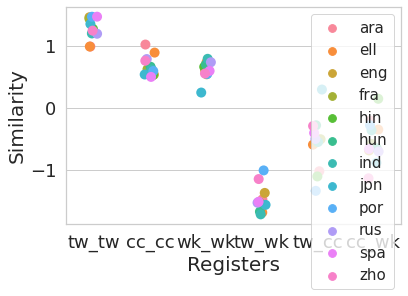

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
sns.set_theme(style="whitegrid")

graph_df = results_df.loc[:,["tw_tw", "cc_cc", "wk_wk", "tw_wk", "tw_cc", "cc_wk"]].stack().to_frame().reset_index() 

graph_df.columns = ["Language", "Registers", "Similarity"]

ax = sns.stripplot(y="Similarity", x="Registers", hue="Language", data=graph_df, size=10)

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
rcParams['font.size'] = 15
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.legend(title='', fontsize=15, title_fontsize=20)
plt.xlabel("Registers",size=20)
plt.ylabel("Similarity",size=20)
plt.tick_params(axis='both', which='major', labelsize=18)

But how accurate is this corpus similarity measure? We test it by using a simple threshold to make predictions. Some pairs of corpora are from the same register and some from different registers. Is there a threshold for each language that can make accurate predictions? Let's find out!

In [8]:
for language, results in full_results_raw:
    
    #Divide pairs into same or different registers
    same_register = results["tw_tw"] + results["cc_cc"] + results["wk_wk"]
    cross_register = results["cc_wk"] + results["tw_wk"] + results["tw_cc"]
    
    #Set a threshold halfway between the lowest and highest values of each
    threshold = (min(same_register) + max(cross_register)) / 2.0
    counter = 0
    
    #Errors from different register pairs being too similar
    for value in cross_register:
        if value > threshold:
            counter += 1
    
    #Errors from same register pairs being too different
    for value in same_register:
        if value < threshold:
            counter += 1
          
    total = len(same_register+cross_register)
    
    print(language, (total-counter)/total)

ara 0.9733333333333334
ell 0.9866666666666667
eng 0.96
fra 1.0
hin 0.9733333333333334
hun 0.98
ind 1.0
jpn 0.8133333333333334
por 0.98
rus 1.0
spa 0.9866666666666667
zho 0.8333333333333334


This shows us the accuracy (% correct). This is a fine measure, much like f-score here because there are the same number of samples for each category. So, the point here is that the measure are pretty accurate for most languages at making class predictions, even though our main goal is to have a continuous measure to compare corpora.

Finally, let's take a look at homogeneity within the same register. In order words, how consistent or stable is a corpora from one source? Let's use the corpus similarity measure as a foundation to looking at the consistency of digital sources of data across these languages.

In [9]:
homogeneity = []
for lang in full_results_standardized:   
    for register_pair in ["tw_tw", "cc_cc", "wk_wk"]:
        for value in lang[register_pair]:
            homogeneity.append([lang["lang"], register_pair[:2], value[0]])

homogeneity_df = pd.DataFrame(homogeneity, columns = ["Language", "Register", "Value"])
print(homogeneity_df)

    Language Register     Value
0        ara       tw  0.970252
1        ara       tw  0.972401
2        ara       tw  0.860069
3        ara       tw  0.978338
4        ara       tw  1.008211
..       ...      ...       ...
895      zho       wk  0.739923
896      zho       wk  0.811656
897      zho       wk  0.902732
898      zho       wk  0.957508
899      zho       wk -1.436242

[900 rows x 3 columns]


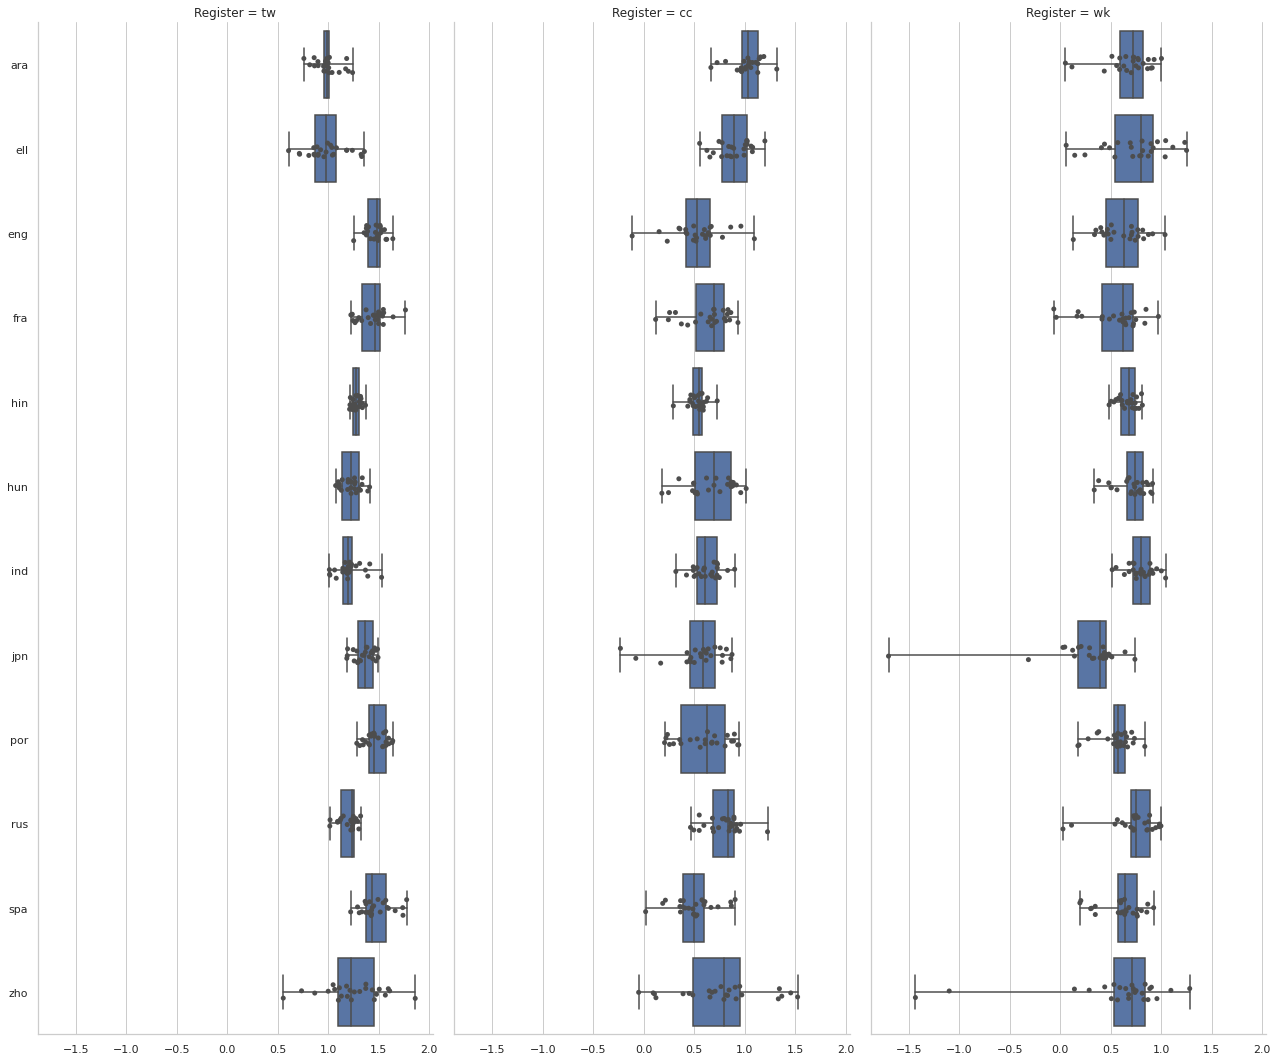

In [10]:
g = sns.FacetGrid(homogeneity_df, col="Register", height=15, aspect = 0.4)

g.map_dataframe(sns.boxplot, x="Value", y="Language", data=homogeneity_df, whis=np.inf)
g.map_dataframe(sns.stripplot, x="Value", y="Language", data=homogeneity_df, color=".3")

So, this is showing us the consistency for each register in each language. When the similarity values are closely clustered together, the corpus is quite homogenous. But when the values are spread out widely, it is more heterogeneous. Below we make a smaller graph.

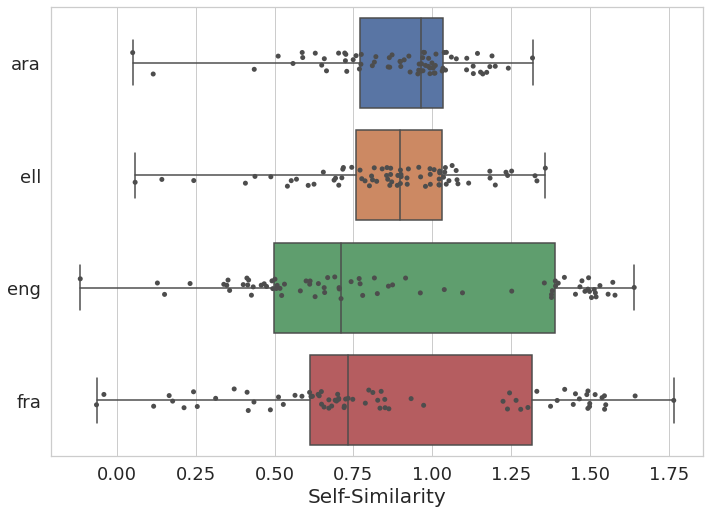

In [11]:
reduced_df = homogeneity_df.loc[homogeneity_df['Language'].isin(["ara", "ell", "eng", "fra"])]
reduced_df.loc[reduced_df['Register'] == "tw"]                                                               

sns.boxplot(x="Value", y="Language", data=reduced_df, whis=np.inf)
sns.stripplot(x="Value", y="Language", data=reduced_df, color=".3")
plt.xlabel("Self-Similarity",size=20)
plt.ylabel("",size=20)
plt.tick_params(axis='both', which='major', labelsize=18)